# Setting learning rates in SPSA

This tutorial explains how you can select and calibrate learning rates for the SPSA optimizer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SPSA

Let's define a toy cost function. For simplicity this one is not based on the expectation value of a quantum mechanical observable.

In [2]:
initial_point = np.array([10, 5])

def f(x):
    return (np.linalg.norm(x) - 1) ** 2

We'll want to keep track of the loss, so let's define a callback to store the values of the loss function.

In [3]:
losses = []
def callback(fnevs, parameters, loss, stepsize, accepted):
    losses.append(loss)

### Constant learning rates

To start off, let's set the learning rates and perturbation to a constant value.

In [4]:
spsa = SPSA(maxiter=100, learning_rate=0.01, perturbation=0.01, callback=callback)

Result: (array([2.12049484, 1.15790681]), 2.0051676859414305, 300)


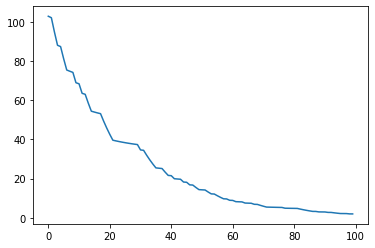

In [5]:
result = spsa.optimize(2, f, initial_point=initial_point)
print('Result:', result)
plt.plot(losses);

### Custom learning rates

SPSA also supports arbitrary learning rates passed as iterators. Since we can call `optimize` multiple times and the iterator needs to start at the beginning again, we have to pass a callable that returns an iterator instead of an iterator directly. 

Typically, SPSA is used with a exponentially decreasing learning rate $\eta_k$ and perturbation $\epsilon_k$:

$$
    \begin{aligned}
    \forall k \in \mathbb N_0:~~ &\eta_k = a \frac{\alpha^k}{1 + A} \\
    &\epsilon_k = c \gamma^k
    \end{aligned}  
$$

where $a, c \in \mathbb R_{>0}$ are scaling coefficents, $\alpha, \beta \in R_{>0}$ determines the decay rate of the learning rate and perturbation and $A \in \mathbb N_0$ is a stability constant. The original SPSA paper suggests $\alpha = 0.602, \gamma = 0.101$ for optimal theoretic convergence properties.

Let's use these powerlaws to define the learning rate and perturbation.

In [6]:
def powerlaw(scaling, rate, stability_constant=0):
    def get_iterator():
        k = 0
        while True:
            yield scaling * rate ** k / (1 + stability_constant)
        
    return get_iterator     

In [7]:
# reset the losses list
losses.clear()

learning_rate = powerlaw(0.1, 0.602, 1)
perturbation = powerlaw(0.2, 0.101)

spsa = SPSA(maxiter=100, learning_rate=learning_rate, perturbation=perturbation, callback=callback)

Result: (array([0.86053708, 0.4970528 ]), 3.877065370174552e-05, 300)


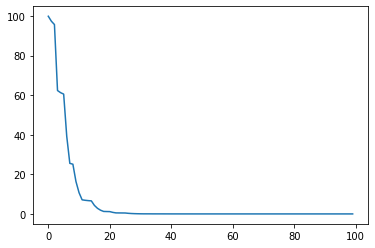

In [8]:
result = spsa.optimize(2, f, initial_point=initial_point)
print('Result:', result)
plt.plot(losses);

### Default learning rates

Per default, the SPSA implementation tries to use an optimal learning rate and perturbation. To do this, we select powerlaw sequences for the iterator and perturbation with the theoretically optimal rates $\alpha$ and $\gamma$ (see above). Additionally, we calibrate the scalings $a, c$ based on the sensitivity of the loss function at the intial point.

Note that this is a heuristic and there's no proof that these automatically calibrated scalings are optimal!

In [9]:
# reset the losses list
losses.clear()

# don't specify learning rate and perturbation
spsa = SPSA(maxiter=100, callback=callback)

Result: (array([4.49306559, 1.8574089 ]), 14.913901949153505, 300)


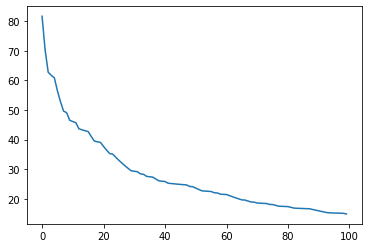

In [10]:
result = spsa.optimize(2, f, initial_point=initial_point)
print('Result:', result)
plt.plot(losses);

You can also obtain the calibrated learning rate and perturbation using the static `calibrate` method of SPSA.

In [11]:
# reset the losses list
losses.clear()

learning_rate, perturbation = SPSA.calibrate(f, initial_point=initial_point)

spsa = SPSA(maxiter=100, learning_rate=learning_rate, perturbation=perturbation, callback=callback)

Result: (array([3.63568175, 0.70168138]), 7.30498966604618, 300)


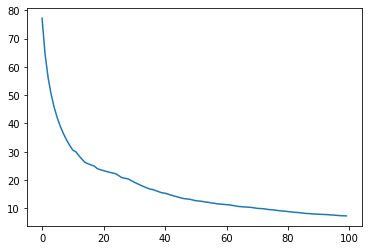

In [12]:
result = spsa.optimize(2, f, initial_point=initial_point)
print('Result:', result)
plt.plot(losses);